In [2]:
# MASTER CELL: CPU INFERENCE MODE
import os

# 1. FORCE CPU (Must be before any other import!)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
# Phase 2: Implementation, Experiments, and Final Report
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping

2025-12-27 15:45:02.232298: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# 1. Global Configuration
# On 4GB VRAM, if you get memory errors, lower batch_size to 16
SEED = 42
img_height = 128
img_width = 128
batch_size = 32 
epochs = 40
k_folds = 3         # Reduced to 3 to save time, or set to 5 if you have time
data_dir = '../data/raw'

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"Device: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.20.0
Device: []


2025-12-27 15:46:20.792585: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


--- Dataset Scan ---
Class 'adenocarcinoma': 5000 images
Class 'benign': 5000 images
Class 'squamous_cell_carcinoma': 5000 images


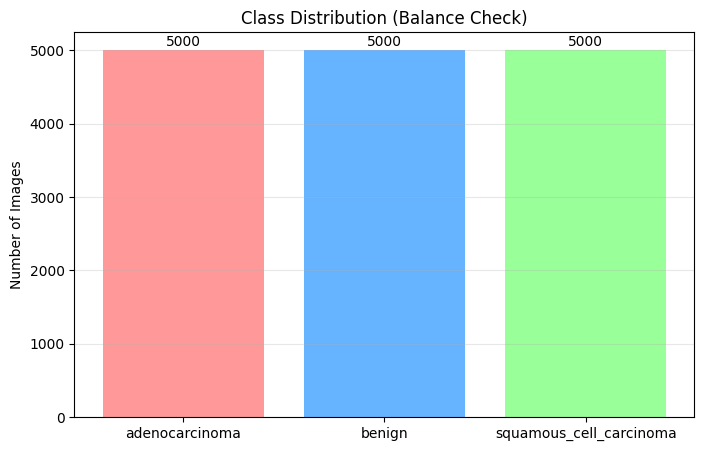

In [4]:
# 2. Data Exploration: Class Distribution
classes = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
class_counts = {}

print("--- Dataset Scan ---")
for c in classes:
    path = os.path.join(data_dir, c)
    if os.path.exists(path):
        num_images = len(os.listdir(path))
        class_counts[c] = num_images
        print(f"Class '{c}': {num_images} images")
    else:
        print(f"Warning: Folder {c} not found.")

# Visualization: Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Class Distribution (Balance Check)')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.3)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, int(yval), ha='center', va='bottom')
plt.show()

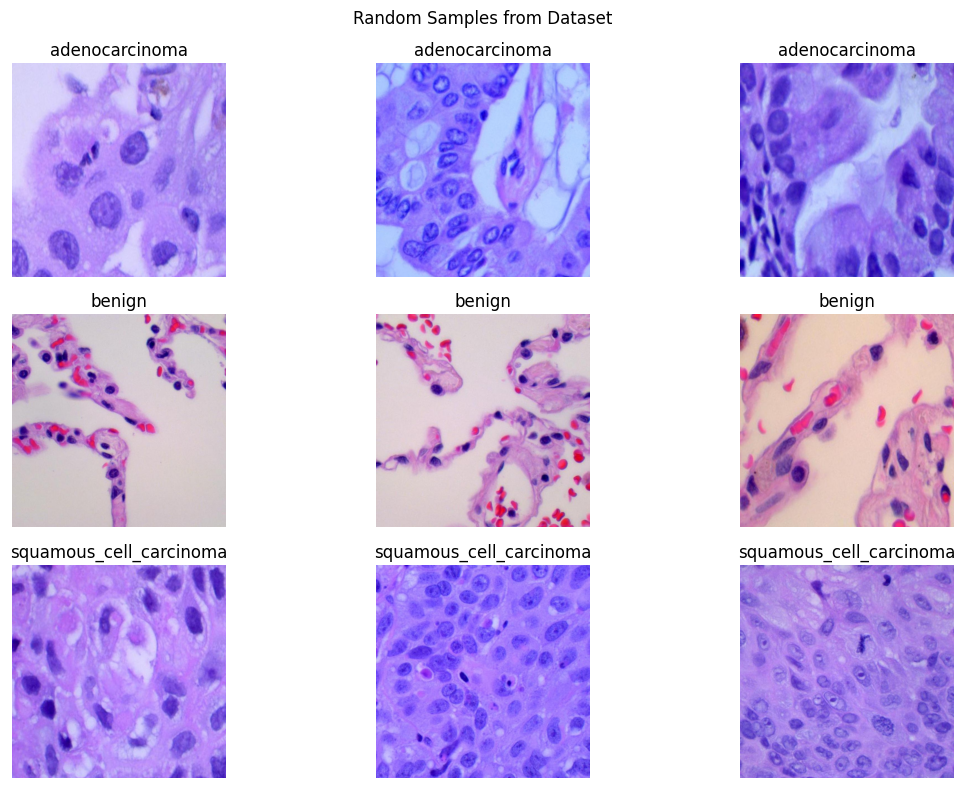

In [5]:
# 3. Data Visualization: Random Samples from Dataset
def plot_random_samples(data_dir, classes, num_samples=3):
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        all_images = os.listdir(class_path)
        selected_images = random.sample(all_images, num_samples)
        
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.suptitle("Random Samples from Dataset")
    plt.tight_layout()
    plt.show()

plot_random_samples(data_dir, classes)

In [6]:
# 4a. Configuration: Final Augmentation Strategy
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Increased to 30
    zoom_range=0.10,        # Reduced to 10% to prevent tumor cropping
    shear_range=0.05,       # Slight geometric distortion
    width_shift_range=0.1,  # Shift horizontal 10%
    height_shift_range=0.1, # Shift vertical 10%
    horizontal_flip=True,   # Mirror image
    fill_mode='nearest'
)

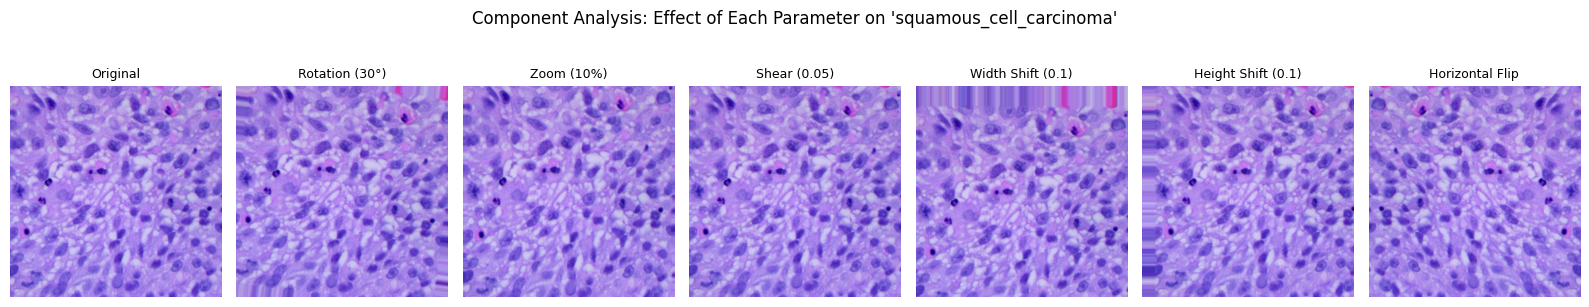

In [7]:
# 4b. Augmentation Study: Isolating Individual Effects
def plot_individual_augmentations(data_dir, classes):
    rand_class = random.choice(classes)
    img_path = os.path.join(data_dir, rand_class, random.choice(os.listdir(os.path.join(data_dir, rand_class))))
    original_img = plt.imread(img_path)
    img_batch = np.expand_dims(original_img, 0)
    
    augmentations = {
        'Original': None,
        'Rotation (30°)': ImageDataGenerator(rotation_range=30, fill_mode='nearest'),
        'Zoom (10%)': ImageDataGenerator(zoom_range=0.10, fill_mode='nearest'),
        'Shear (0.05)': ImageDataGenerator(shear_range=0.05, fill_mode='nearest'),
        'Width Shift (0.1)': ImageDataGenerator(width_shift_range=0.1, fill_mode='nearest'),
        'Height Shift (0.1)': ImageDataGenerator(height_shift_range=0.1, fill_mode='nearest'),
        'Horizontal Flip': ImageDataGenerator(horizontal_flip=True)
    }
    
    plt.figure(figsize=(16, 3))
    for i, (name, gen) in enumerate(augmentations.items()):
        plt.subplot(1, 7, i + 1)
        if gen is None:
            plt.imshow(original_img)
        else:
            aug_iter = gen.flow(img_batch, batch_size=1)
            aug_img = next(aug_iter)[0].astype('uint8')
            plt.imshow(aug_img)
        plt.title(name, fontsize=9)
        plt.axis('off')
    plt.suptitle(f"Component Analysis: Effect of Each Parameter on '{rand_class}'", y=1.05)
    plt.tight_layout()
    plt.show()

plot_individual_augmentations(data_dir, classes)

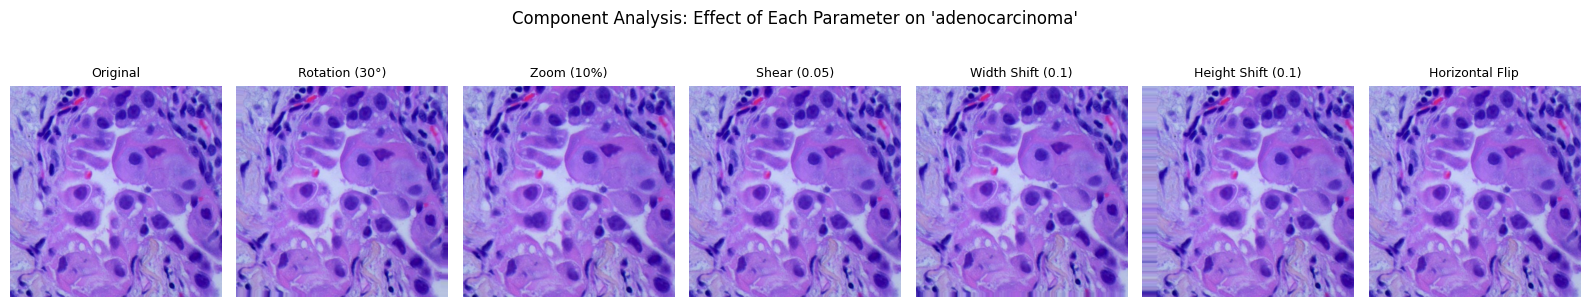

In [8]:
# 4b. Augmentation Study: Isolating Individual Effects
def plot_individual_augmentations(data_dir, classes):
    rand_class = random.choice(classes)
    img_path = os.path.join(data_dir, rand_class, random.choice(os.listdir(os.path.join(data_dir, rand_class))))
    original_img = plt.imread(img_path)
    img_batch = np.expand_dims(original_img, 0)
    
    augmentations = {
        'Original': None,
        'Rotation (30°)': ImageDataGenerator(rotation_range=30, fill_mode='nearest'),
        'Zoom (10%)': ImageDataGenerator(zoom_range=0.10, fill_mode='nearest'),
        'Shear (0.05)': ImageDataGenerator(shear_range=0.05, fill_mode='nearest'),
        'Width Shift (0.1)': ImageDataGenerator(width_shift_range=0.1, fill_mode='nearest'),
        'Height Shift (0.1)': ImageDataGenerator(height_shift_range=0.1, fill_mode='nearest'),
        'Horizontal Flip': ImageDataGenerator(horizontal_flip=True)
    }
    
    plt.figure(figsize=(16, 3))
    for i, (name, gen) in enumerate(augmentations.items()):
        plt.subplot(1, 7, i + 1)
        if gen is None:
            plt.imshow(original_img)
        else:
            aug_iter = gen.flow(img_batch, batch_size=1)
            aug_img = next(aug_iter)[0].astype('uint8')
            plt.imshow(aug_img)
        plt.title(name, fontsize=9)
        plt.axis('off')
    plt.suptitle(f"Component Analysis: Effect of Each Parameter on '{rand_class}'", y=1.05)
    plt.tight_layout()
    plt.show()

plot_individual_augmentations(data_dir, classes)

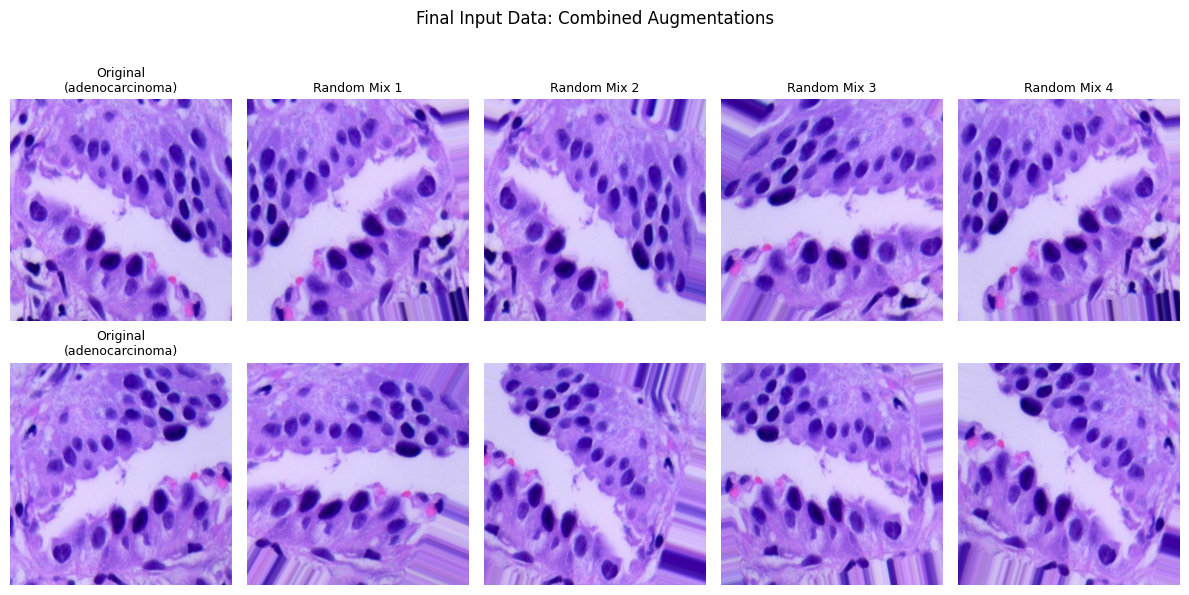

In [9]:
# 4c. Final Verification: Combined Effects
def visualize_augmentation(data_dir, classes, num_examples=2):
    plt.figure(figsize=(12, 6))
    for row in range(num_examples):
        rand_class = random.choice(classes)
        img_path = os.path.join(data_dir, rand_class, random.choice(os.listdir(os.path.join(data_dir, rand_class))))
        original_img = plt.imread(img_path)
        img_batch = np.expand_dims(original_img, 0)
        
        plt.subplot(num_examples, 5, (row * 5) + 1)
        plt.imshow(original_img)
        plt.title(f"Original\n({rand_class})", fontsize=9)
        plt.axis('off')
        
        iterator = aug_datagen.flow(img_batch, batch_size=1)
        for col in range(4):
            aug_img = next(iterator)[0]
            plt.subplot(num_examples, 5, (row * 5) + col + 2)
            plt.imshow(aug_img)
            plt.axis('off')
            if row == 0:
                plt.title(f"Random Mix {col+1}", fontsize=9)
    plt.suptitle(f"Final Input Data: Combined Augmentations", y=1.02)
    plt.tight_layout()
    plt.show()

visualize_augmentation(data_dir, classes)

In [10]:
# 5. Model Definition: Transfer Learning (VGG16)
def build_transfer_model(input_shape=(128, 128, 3), num_classes=3, learning_rate=0.001):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the Base
    for layer in base_model.layers:
        layer.trainable = False
        
    # Add Custom Head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Quick compilation check
print("Building VGG16 Transfer Model check...")
temp = build_transfer_model()
temp.summary()

Building VGG16 Transfer Model check...


I0000 00:00:1766837683.166802   15920 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2247 MB memory:  -> device: 0, name: Quadro T1000, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,867 (64.14 MB)

 Trainable params: 2,098,179 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# 6. Data Preparation for Cross-Validation (Mapping files to DataFrame)
def create_file_dataframe(data_dir):
    filepaths = []
    labels = []
    classes = sorted(os.listdir(data_dir))
    
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            file_names = os.listdir(class_dir)
            for fname in file_names:
                fpath = os.path.join(class_dir, fname)
                filepaths.append(fpath)
                labels.append(class_name)
    
    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True) # Shuffle
    return df

print("Creating Master DataFrame...")
full_df = create_file_dataframe(data_dir)
print(f"Total Images: {len(full_df)}")
print(full_df['label'].value_counts())

Creating Master DataFrame...
Total Images: 15000
label
squamous_cell_carcinoma    5000
benign                     5000
adenocarcinoma             5000
Name: count, dtype: int64


In [12]:
# 7. Cross-Validation Engine
val_datagen = ImageDataGenerator(rescale=1./255) # No augmentation for validation

def run_cross_validation(df, learning_rate):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    fold_accuracies = []
    fold_losses = []
    
    y = df['label']
    
    print(f"\n--- Starting {k_folds}-Fold Cross-Validation ---")
    print(f"Parameters: LR={learning_rate}, Batch={batch_size}")

    for fold, (train_idx, val_idx) in enumerate(skf.split(df, y)):
        print(f"\nTraining Fold {fold + 1}/{k_folds}...")
        
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        
        train_gen = aug_datagen.flow_from_dataframe(
            dataframe=train_df,
            x_col='filepath', y_col='label',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )
        
        val_gen = val_datagen.flow_from_dataframe(
            dataframe=val_df,
            x_col='filepath', y_col='label',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        model = build_transfer_model(learning_rate=learning_rate)
        
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
        
        # verbose=2 prints one line per epoch (cleaner)
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            callbacks=[early_stop],
            verbose=2 
        )
        
        best_acc = max(history.history['val_accuracy'])
        best_loss = min(history.history['val_loss'])
        
        fold_accuracies.append(best_acc)
        fold_losses.append(best_loss)
        print(f"--> Fold {fold + 1} Result: Accuracy={best_acc:.4f} | Loss={best_loss:.4f}")
        
    avg_acc = np.mean(fold_accuracies)
    print(f"\n=== Cross-Validation Complete ===")
    print(f"Average Accuracy: {avg_acc:.4f} (+/- {np.std(fold_accuracies):.4f})")
    
    # Return history of the LAST fold just for plotting shapes if needed, plus stats
    return avg_acc, fold_accuracies

Running Experiments on 3 Learning Rates...
Folds per Experiment: 3

##################################################
 EXPERIMENT: Learning Rate = 0.01
##################################################

--- Starting 3-Fold Cross-Validation ---
Parameters: LR=0.01, Batch=32

Training Fold 1/3...
Found 10000 validated image filenames belonging to 3 classes.
Found 5000 validated image filenames belonging to 3 classes.
Epoch 1/40


2025-12-27 06:04:38.070386: I external/local_xla/xla/service/service.cc:163] XLA service 0x73bedc002540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-27 06:04:38.070496: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro T1000, Compute Capability 7.5
2025-12-27 06:04:38.124082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-27 06:04:38.524008: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2025-12-27 06:04:39.391597: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,128,128]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

313/313 - 277s - 885ms/step - accuracy: 0.8184 - loss: 1.0620 - val_accuracy: 0.9368 - val_loss: 0.1832
Epoch 2/40
313/313 - 127s - 406ms/step - accuracy: 0.8680 - loss: 0.3413 - val_accuracy: 0.9362 - val_loss: 0.1536
Epoch 3/40
313/313 - 136s - 434ms/step - accuracy: 0.8663 - loss: 0.3439 - val_accuracy: 0.9480 - val_loss: 0.1556
Epoch 4/40
313/313 - 140s - 447ms/step - accuracy: 0.8524 - loss: 0.3796 - val_accuracy: 0.9476 - val_loss: 0.2176
Epoch 5/40
313/313 - 154s - 491ms/step - accuracy: 0.8655 - loss: 0.3518 - val_accuracy: 0.9336 - val_loss: 0.1648
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
--> Fold 1 Result: Accuracy=0.9480 | Loss=0.1536

Training Fold 2/3...
Found 10000 validated image filenames belonging to 3 classes.
Found 5000 validated image filenames belonging to 3 classes.
Epoch 1/40
313/313 - 133s - 424ms/step - accuracy: 0.8510 - loss: 0.6722 - val_accuracy: 0.9228 - val_loss: 0.1942
Epoch 2/40
313/313 - 143s - 458ms/step - acc

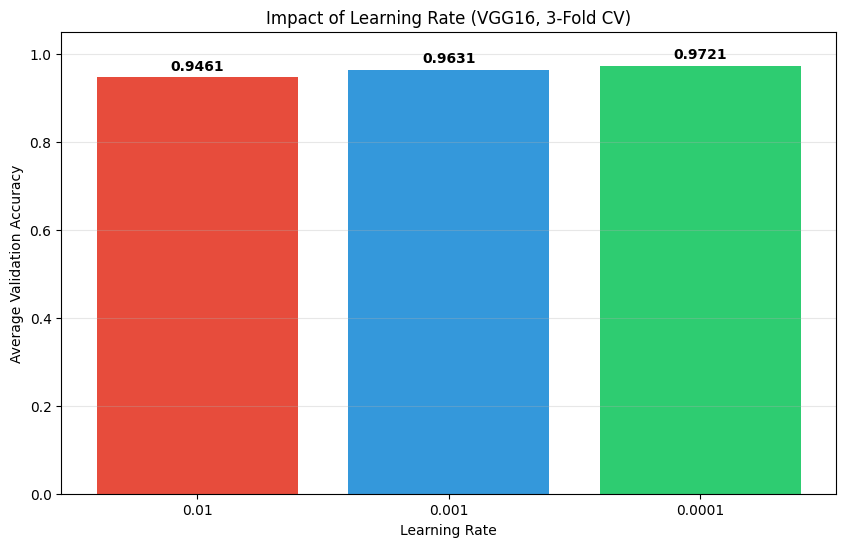


--- Final Summary ---
LR 0.01: 94.61% Accuracy
LR 0.001: 96.31% Accuracy
LR 0.0001: 97.21% Accuracy


In [12]:
# 8. Experiment: Learning Rate Comparison
# This will run the CV loop 3 times (once for each LR).

learning_rates = [0.01, 0.001, 0.0001]
results_acc = []

print(f"Running Experiments on {len(learning_rates)} Learning Rates...")
print(f"Folds per Experiment: {k_folds}")

for lr in learning_rates:
    print(f"\n##################################################")
    print(f" EXPERIMENT: Learning Rate = {lr}")
    print(f"##################################################")
    
    avg_acc, _ = run_cross_validation(full_df, learning_rate=lr)
    results_acc.append(avg_acc)

# --- Visualization of Results ---
plt.figure(figsize=(10, 6))
x_pos = [str(lr) for lr in learning_rates]
bars = plt.bar(x_pos, results_acc, color=['#e74c3c', '#3498db', '#2ecc71'])
plt.title(f'Impact of Learning Rate (VGG16, {k_folds}-Fold CV)')
plt.xlabel('Learning Rate')
plt.ylabel('Average Validation Accuracy')
plt.ylim(0.0, 1.05) 
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom', fontweight='bold')

plt.show()

print("\n--- Final Summary ---")
for i, lr in enumerate(learning_rates):
    print(f"LR {lr}: {results_acc[i]*100:.2f}% Accuracy")

In [15]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Found 12000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.

Training Final VGG16 Model (LR=0.0001)...
Epoch 1/40


2025-12-27 14:17:05.220304: I external/local_xla/xla/service/service.cc:163] XLA service 0x774d3000cc40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-27 14:17:05.220338: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro T1000, Compute Capability 7.5
2025-12-27 14:17:05.283445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-27 14:17:05.726440: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2025-12-27 14:17:06.489258: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,128,128]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:04:33 10s/step - accuracy: 0.5312 - loss: 1.0212

I0000 00:00:1766837834.195509   16038 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8149 - loss: 0.4397

2025-12-27 14:21:16.617878: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,128,128]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-27 14:21:16.721907: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,128,128]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

375/375 ━━━━━━━━━━━━━━━━━━━━ 259s 664ms/step - accuracy: 0.8874 - loss: 0.2856 - val_accuracy: 0.9473 - val_loss: 0.1565
Epoch 2/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 342ms/step - accuracy: 0.9331 - loss: 0.1715 - val_accuracy: 0.9583 - val_loss: 0.1189
Epoch 3/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 129s 345ms/step - accuracy: 0.9394 - loss: 0.1490 - val_accuracy: 0.9593 - val_loss: 0.1192
Epoch 4/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 341ms/step - accuracy: 0.9450 - loss: 0.1392 - val_accuracy: 0.9607 - val_loss: 0.1106
Epoch 5/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 126s 337ms/step - accuracy: 0.9473 - loss: 0.1314 - val_accuracy: 0.9630 - val_loss: 0.0969
Epoch 6/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 146s 388ms/step - accuracy: 0.9524 - loss: 0.1239 - val_accuracy: 0.9650 - val_loss: 0.1021
Epoch 7/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 126s 335ms/step - accuracy: 0.9548 - loss: 0.1165 - val_accuracy: 0.9660 - val_loss: 0.0892
Epoch 8/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 342ms/step - accuracy: 0.9535 - loss: 0.11

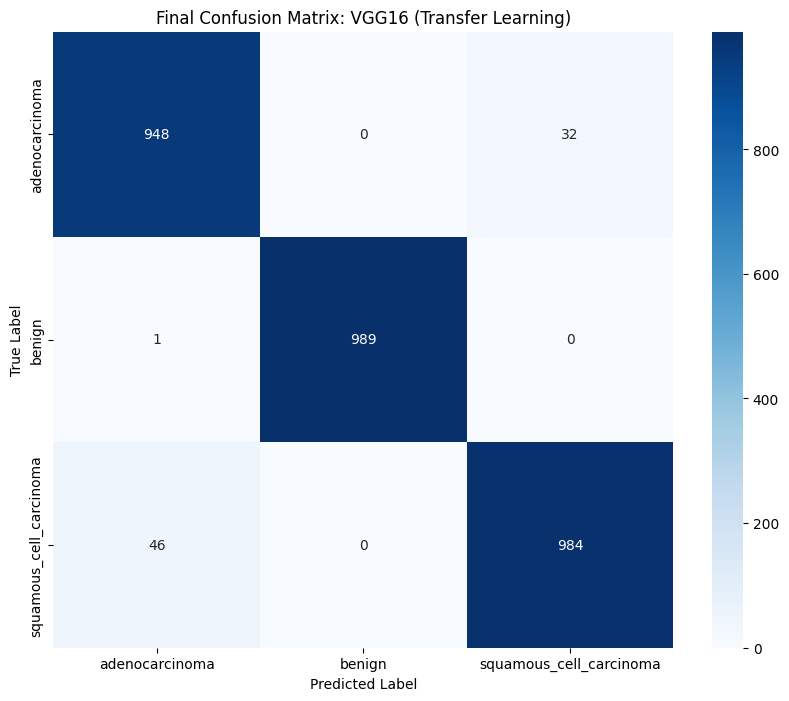

In [16]:
# 9. Final Evaluation of the Champion Model (VGG16 @ LR=0.0001)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# A. Split Data one last time (80/20) for the Final Matrix
# We use the same seed to ensure fairness
train_df = full_df.sample(frac=0.8, random_state=SEED)
val_df = full_df.drop(train_df.index)

# B. Generators
train_gen_final = aug_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen_final = val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # No shuffle for Confusion Matrix!
)

# C. Train the Champion
print("\nTraining Final VGG16 Model (LR=0.0001)...")
final_model = build_transfer_model(learning_rate=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_final = final_model.fit(
    train_gen_final,
    validation_data=val_gen_final,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=1
)

# D. Generate Matrix
print("\nGenerating Final Predictions...")
predictions = final_model.predict(val_gen_final)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_gen_final.classes
class_labels = list(val_gen_final.class_indices.keys())

# E. Plot
print("\n--- VGG16 Classification Report ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Final Confusion Matrix: VGG16 (Transfer Learning)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

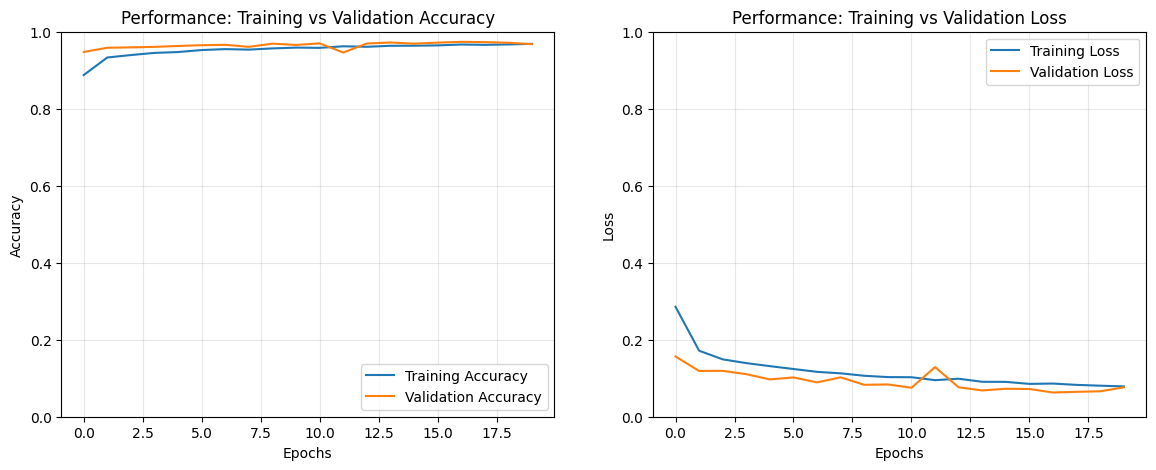

Final Test Accuracy: 97.37%


In [20]:
#Performance Curves
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Performance: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Performance: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

final_acc = np.mean(predicted_classes == true_classes)
print(f"Final Test Accuracy: {final_acc*100:.2f}%")

In [21]:
save_path = 'lung_cancer_vgg16_model.h5' # .h5 is the standard for student projects
final_model.save(save_path)

print(f"Success! Model saved to: {os.path.abspath(save_path)}")
print(f"File Size: {os.path.getsize(save_path) / 1_000_000:.2f} MB")

Success! Model saved to: /mnt/c/Users/Ezzat Gad/OneDrive/Desktop/AI/Project/notebooks/lung_cancer_vgg16_model.h5
File Size: 84.13 MB


In [5]:
# Using the model for later:
from tensorflow.keras.models import load_model
final_model = load_model('../models/lung_cancer_vgg16_model.h5')
# Use loaded_model.predict()

Random chose adenocarcinoma
So, it chooses folder ../data/raw/adenocarcinoma
It chose image number 0767.jpg
Image path: ../data/raw/adenocarcinoma/0767.jpg
So, true Label is: adenocarcinoma


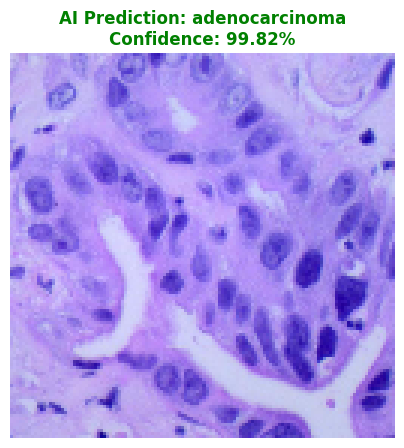

Raw Probabilities: [9.9816006e-01 2.9327005e-06 1.8369401e-03]


'adenocarcinoma'

In [7]:
# 12. Inference (Testing Model)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

class_labels = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

def predict_single_image(model, img_path):
    # target size (128x128)
    img = load_img(img_path, target_size=(128, 128))
    
    # To Array (128, 128, 3)
    img_array = img_to_array(img)
    
    # Must rescale!!
    img_array = img_array / 255.0
    
    # Batch Dimension
    # The model expects a list of images, even if it's just one.
    # Turns (128, 128, 3) into (1, 128, 128, 3)
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Predict
    prediction_scores = model.predict(img_batch, verbose=0)
    predicted_index = np.argmax(prediction_scores)
    predicted_label = class_labels[predicted_index]
    confidence = prediction_scores[0][predicted_index]
    
    # Display Result
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    
    # Green if confident (>80%), Red if unsure
    title_color = 'green' if confidence > 0.8 else 'red'
    
    plt.title(f"AI Prediction: {predicted_label}\nConfidence: {confidence*100:.2f}%", 
              color=title_color, fontsize=12, fontweight='bold')
    plt.show()
    
    print(f"Raw Probabilities: {prediction_scores[0]}")
    return predicted_label

# Test from the dataset
rand_class = random.choice(class_labels)
print(f"Random chose {rand_class}")
rand_folder = os.path.join(data_dir, rand_class)
print(f"So, it chooses folder {rand_folder}")
rand_file = random.choice(os.listdir(rand_folder))
print(f"It chose image number {rand_file}")
random_image_path = os.path.join(rand_folder, rand_file)
print(f"Image path: {random_image_path}")
print(f"So, true Label is: {rand_class}")
predict_single_image(final_model, random_image_path)